# Nicolás Torres-Echeverry: 
# Homework 2 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy
import nltk
import gensim

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile
import re

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

In [2]:
# Taking warnigs out
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting figure sizes
%matplotlib inline
sns.set(rc={'figure.figsize':(11, 11)})

# <span style="color:red">*0. Helper functions:*</span>
----------------

In [4]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [5]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [6]:
## Here are my own functions to lemmatize and normalize

def normalize(text):
    '''
    Normalizes: takes out punctuation and stopwords (defined by SpaCy) 
    Input:
        text (str): text made of string
    
    Output:
        lexical_tokens(list): list of strings. Text has been clean of puntuation, numbers,
                        stop words, and made lower case
    '''
    test = nlp(text)
    words = [t.orth_ for t in test if not t.is_punct | t.is_stop] #here is filtering
    lexical_tokens = [t.lower() for t in words if t.isalpha()] #make lowercase and leave nonnumerical
    
    return lexical_tokens

def lemmatizer(text):
    '''
    Lemmatizes a text using the SpaCy lemmatizer, which makes errors 
    '''
    test = nlp(text)
    lemmas = [tok.lemma_.lower() for tok in test]
    
    return lemmas


def lematize_list(word_list):
    '''
    Takes a list of words and applies the lematizer function
    
    Input:
        word_list(list)
    
    Output:
        lem_list(list): list of lemmatized words
        
    '''
    lem_list=[]
    for word in word_list:
        lem_word = lemmatizer(word)
        lem_list.append(lem_word[0])
    
    return lem_list


In [7]:
def sent_tokenize_spanish(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [8]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pandas.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [9]:
def tag_sents_pos_spanish(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.pos_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [10]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [11]:
def spacy_pos(word_list):
    tags = []
    doc = nlp_en(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [12]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

# <span style="color:red">*Exercise 1: Getting and working with raw text*</span>
----------------

Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question.

### Colombian candidates for president (2010, 2014, 2018) and for Bogotá's mayoral office (2011, 2015, 2019)

#### I want to see how candidates that use diverse political practices express themselves in Twitter and how their online discuse has varied over the 2010-2019 period. I will use a dataset I scraped previously from these candidates' Twitter profiles.

In [13]:
# Checking in which directory I am and what's in it
os.getcwd()
os.listdir()

['.DS_Store',
 'whitehouse_word_cloud.pdf',
 '2-class_code_hw2.ipynb',
 'clean_data.csv',
 '2-nte_toecn_hw2.ipynb',
 '.ipynb_checkpoints',
 'twitter_speech_cand_col.pdf']

In [14]:
# Importing data
df_twitter = pandas.read_csv('clean_data.csv')

In [15]:
# Cheacking the number of observations and variables
df_twitter.shape

(665235, 22)

In [16]:
df_twitter.columns

Index(['Unnamed: 0', 'has_media', 'hashtags', 'img_urls', 'is_replied',
       'is_reply_to', 'likes', 'links', 'parent_tweet_id', 'replies',
       'reply_to_users', 'retweets', 'screen_name', 'text', 'text_html',
       'timestamp', 'timestamp_epochs', 'tweet_id', 'tweet_url', 'user_id',
       'username', 'video_url'],
      dtype='object')

#### Because the dataset is too big to work with, I'll be using a sample of 10,000 tweets

In [17]:
df_twitter_10000 = df_twitter.sample(10000, random_state=132)

In [18]:
df_twitter_10000.shape

(10000, 22)

#### Because I'm interested in variation over time, I'll use the following function to extract the date attributes of the tweets. Then, Ill group by year, month.

In [19]:
df_twitter_10000['date-column'] = lookup(df_twitter_10000['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_twitter_10000['date-column'] = pandas.to_datetime(df_twitter_10000['date-column'])
df_twitter_10000['year'] = df_twitter_10000['date-column'].dt.year
df_twitter_10000['month'] = df_twitter_10000['date-column'].dt.month

In [20]:
# Sometimes the text column has other objects than strings, so to check that they are all strings:
df_twitter_10000['text'] = df_twitter_10000['text'].astype(str)

In [21]:
grouped_data = df_twitter_10000.groupby(['username', 'year'])['text'].apply('/'.join).reset_index()
grouped_data_sum = df_twitter_10000.groupby(['username', 'year'])['likes'].apply(sum).reset_index()
grouped_data['sum_likes'] = grouped_data_sum['likes']
grouped_data.shape

(191, 4)

# The dataframe looks good. Now lets tokenize.
#### Because the tweets are in spanish, I'll be using "es_core_news_sm"

In [22]:
nlp = spacy.load("es_core_news_sm")

In [23]:
# Some text cleaning using regular expressions

grouped_data['text2'] = grouped_data['text'].apply(lambda x: re.sub('[¡!@#$:).;,¿?&]', '', x.lower()))
grouped_data['normalized_text'] = grouped_data['text2'].apply(lambda x: normalize(x))

In [24]:
grouped_data['len_tokens_no_sw'] = grouped_data['normalized_text'].apply(lambda x: len(x))

In [25]:
grouped_data[['username', 'year', 'len_tokens_no_sw', 'sum_likes']][10:20]

,username,year,len_tokens_no_sw,sum_likes
10,Antanas Mockus,2019.0,68,2247.0
11,Carlos F. Galán,2010.0,53,1.0
12,Carlos F. Galán,2011.0,508,72.0
13,Carlos F. Galán,2012.0,283,65.0
14,Carlos F. Galán,2013.0,582,129.0
15,Carlos F. Galán,2014.0,414,835.0
16,Carlos F. Galán,2015.0,266,705.0
17,Carlos F. Galán,2016.0,192,1285.0
18,Carlos F. Galán,2017.0,157,1559.0
19,Carlos F. Galán,2018.0,356,11347.0


### *Hypothesis*: there is a positive correlation between the number of tokens without stop words and the engament meassured as likes. 

<AxesSubplot:xlabel='len_tokens_no_sw', ylabel='sum_likes'>

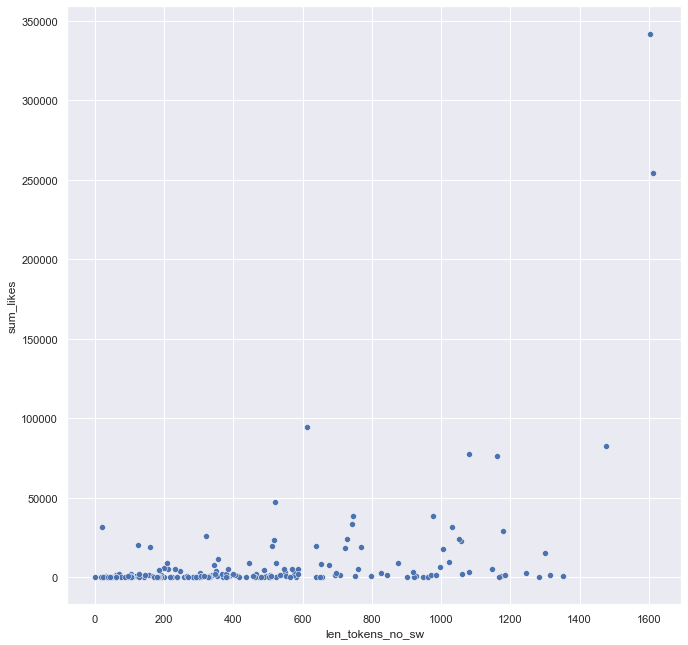

In [26]:
# Testing my hypothesis with a scatter plot and pearson's correlation

%matplotlib inline
sns.set(rc={'figure.figsize':(11, 11)})

sns.scatterplot(data=grouped_data, x="len_tokens_no_sw", y="sum_likes")

In [27]:
grouped_data["len_tokens_no_sw"].corr(grouped_data["sum_likes"]) 

0.431681424314293

### There is support for this hypothesis. Perhaps less aparent in the scatter plot, but the pearson's correlation coefficient of 0.5 allows us to see this more clearly. The result, however, should not surprise us because more tokens are correlated with more tweets that increase the probability of exposure and, therefore, of likes.


----------


## <span style="color:red">*Exercise 2: Filtering and lemmatizing*</span>

Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a world of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.

## Lemmatization

In [29]:
grouped_data['lemmatized_text'] = grouped_data['normalized_text'].apply(lambda x: lematize_list(x))
#THIS IS COMPUTATIONALLY INEFFICIENT, FIND SOLUTION

In [30]:
countsDict = {}
for word in grouped_data['lemmatized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('y', 4632),
 ('a', 4102),
 ('bogotá', 711),
 ('colombia', 583),
 ('q', 481),
 ('gracia', 473),
 ('país', 417),
 ('paz', 413),
 ('gobernar', 366),
 ('político', 320),
 ('ciudad', 317),
 ('año', 303),
 ('santo', 293),
 ('colombiano', 292),
 ('apoyar', 285),
 ('seguir', 266),
 ('público', 213),
 ('construir', 212),
 ('presidente', 205),
 ('educación', 205)]

#### There are still a number of words that should not show up here. In the future, I'll have to see how to include them in the stop words.

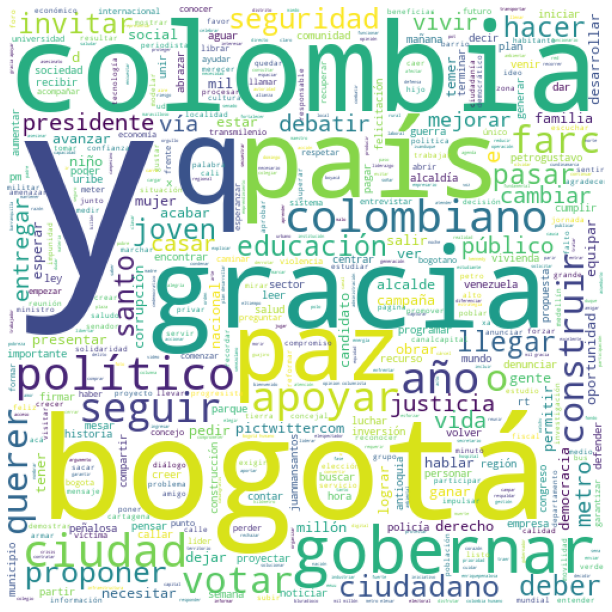

In [31]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(grouped_data['lemmatized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("twitter_speech_cand_col.pdf", format = 'pdf')

### It is evident from the wordcloud and wordcounts that this corpus is produced in the context of politics regarding the Colombian presidential elections and Bogotá's mayoral elections. 

### Some interesting things:
#### - Seguridad (security), paz (peace), farc show up
#### - The names of the most promininent political figures do as well

In [32]:
# USING NLTK

#.sum() adds together the lists from each row into a single list
tweets_cfdist = nltk.ConditionalFreqDist(((len(w), w) for w in grouped_data['lemmatized_text'].sum()))

#print the number of words
print(tweets_cfdist.N())

90231


In [33]:
tweets_cfdist[4]

FreqDist({'país': 417, 'farc': 187, 'vida': 163, 'niño': 126, 'plan': 103, 'leer': 97, 'hora': 91, 'unir': 81, 'zona': 76, 'juan': 71, ...})

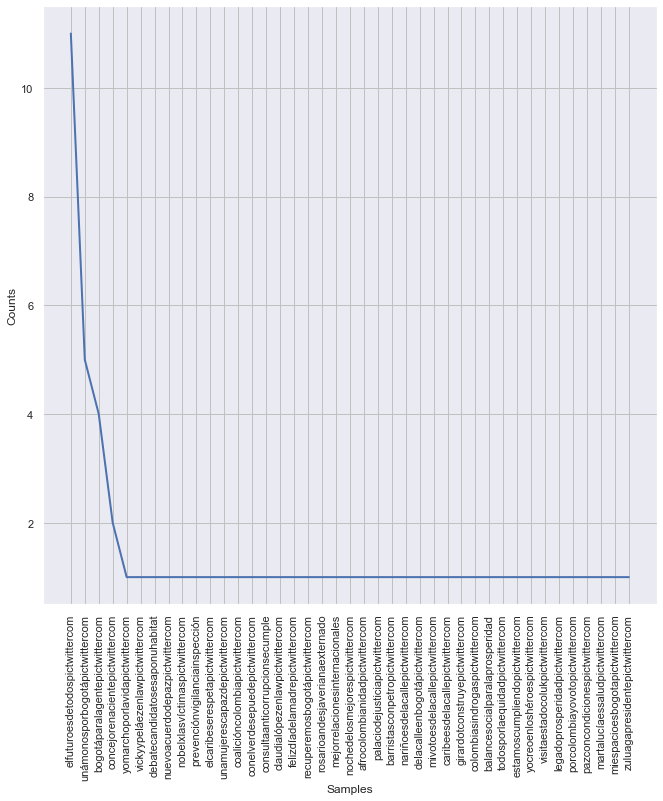

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [34]:
# The counts of words of 30 letters show campaing slogans:

tweets_cfdist[30].plot()

In [35]:
tweets_pdist = nltk.ConditionalProbDist(tweets_cfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(tweets_pdist[2].max())

#And its probability
print(tweets_pdist[2].prob(tweets_pdist[2].max()))

rt
0.11510353227771011


#### Of course the most probable two letter word is rt, which stands for retweet!!!! 

## <span style="color:red">*Your turn*</span>

In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [36]:
grouped_data.columns

Index(['username', 'year', 'text', 'sum_likes', 'text2', 'normalized_text',
       'len_tokens_no_sw', 'lemmatized_text'],
      dtype='object')

In [37]:
grouped_data['sentences'] = grouped_data['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize_spanish(x)])
grouped_data.index = range(len(grouped_data) - 1, -1,-1) #Reindex to make things nice in the future
grouped_data

,username,year,text,sum_likes,text2,normalized_text,len_tokens_no_sw,lemmatized_text,sentences
190,Antanas Mockus,2009.0,http://bit.ly/4nmO0E/Las circunstancias políti...,3.0,http//bitly/4nmo0e/las circunstancias política...,"[circunstancias, políticas, actuales, exigen, ...",28,"[circunstancia, político, actual, exigir, gent...","[[http://bit.ly/4nmO0E/Las, circunstancias, po..."
189,Antanas Mockus,2010.0,@burrinsky Comunicarse con Henry Murrain h.mur...,41.0,burrinsky comunicarse con henry murrain hmurra...,"[burrinsky, comunicarse, henry, murrain, hmurr...",257,"[burrinsky, comunicarse, henrio, murrain, hmur...","[[@burrinsky, Comunicarse, con, Henry, Murrain..."
188,Antanas Mockus,2011.0,"Ya fui Alcalde 2 veces, uds saben: calidad de ...",51.0,ya fui alcalde 2 veces uds saben calidad de la...,"[alcalde, uds, calidad, gestión, calidad, equi...",200,"[alcalde, uds, calidad, gestión, calidad, equi...","[[Ya, fui, Alcalde, 2, veces, uds, saben, cali..."
187,Antanas Mockus,2012.0,@almatengoyo Reducir violencia es prioridad pa...,1.0,almatengoyo reducir violencia es prioridad par...,"[almatengoyo, reducir, violencia, prioridad, m...",27,"[almatengoyo, reducir, violencia, prioridad, m...","[[@almatengoyo, Reducir, violencia, es, priori..."
186,Antanas Mockus,2013.0,"No insistimos en causar división, querida CLOP...",32.0,no insistimos en causar división querida clope...,"[insistimos, causar, división, querida, clopez...",22,"[insistir, causar, división, querido, clopezan...","[[No, insistimos, en, causar, división, querid..."
...,...,...,...,...,...,...,...,...,...
4,Óscar Iván Zuluaga,2015.0,Te recomiendo esta noticia que encontré en el ...,2240.0,te recomiendo esta noticia que encontré en el ...,"[recomiendo, noticia, encontré, app, opinion, ...",348,"[recomer, noticiar, encontrar, app, opinion, c...","[[Te, recomiendo, esta, noticia, que, encontré..."
3,Óscar Iván Zuluaga,2016.0,"Apreciado Víctor, le agradezco su apoyo y soli...",5212.0,apreciado víctor le agradezco su apoyo y solid...,"[apreciado, víctor, agradezco, apoyo, y, solid...",568,"[apreciar, víctor, agradecer, apoyar, y, solid...","[[Apreciado, Víctor, le, agradezco, su, apoyo,..."
2,Óscar Iván Zuluaga,2017.0,Invitamos a los metenses al plantón (02Feb) en...,5121.0,invitamos a los metenses al plantón (02feb en ...,"[invitamos, a, metenses, plantón, villavicenci...",385,"[invitar, a, metenses, plantón, villavicencio,...","[[Invitamos, a, los, metenses, al, plantón, 02..."
1,Óscar Iván Zuluaga,2018.0,Debatimos con líderes políticos y dirigentes e...,5039.0,debatimos con líderes políticos y dirigentes e...,"[debatimos, líderes, políticos, y, dirigentes,...",230,"[debatir, líder, político, y, dirigente, empre...","[[Debatimos, con, líderes, políticos, y, dirig..."


In [38]:
grouped_data['POS_sents'] = grouped_data['sentences'].apply(lambda x: tag_sents_pos_spanish(x))

In [39]:
grouped_data['POS_sents'][4]

[[('Te', 'PRON'),
  ('recomiendo', 'VERB'),
  ('esta', 'DET'),
  ('noticia', 'NOUN'),
  ('que', 'SCONJ'),
  ('encontré', 'VERB'),
  ('en', 'ADP'),
  ('el', 'DET'),
  ('app', 'PROPN'),
  ('de', 'ADP'),
  ('EL', 'DET'),
  ('TIEMPO', 'PROPN'),
  ('http://app.eltiempo.com/opinion/columnistas/una-gruesa-linea-roja-gustavo-duncan-columna-el-tiempo/16447351',
   'AUX'),
  ('/Denuncia', 'NOUN'),
  ('de', 'ADP'),
  ('nuestro', 'DET'),
  ('candidato', 'NOUN'),
  ('Concejo', 'PROPN'),
  ('Cartagena', 'PROPN'),
  ('Luis', 'PROPN'),
  ('Guillmo', 'PROPN'),
  ('Otoya', 'PROPN'),
  ('sobre', 'ADP'),
  ('fraude', 'NOUN'),
  ('produce', 'VERB'),
  ('intervención', 'NOUN'),
  ('de', 'ADP'),
  ('Fiscalíapic.twitter.com/7iCEfgAa11/@ginaparody', 'PROPN'),
  ('el', 'DET'),
  ('gobierno', 'PROPN'),
  ('Uribe', 'PROPN'),
  ('desmontó', 'VERB'),
  ('el', 'DET'),
  ('paramilitarismo', 'NOUN'),
  ('lo', 'PRON'),
  ('sometió', 'VERB'),
  ('a', 'ADP'),
  ('la', 'DET'),
  ('justicia', 'NOUN'),
  ('le', 'PRON'),
  (

In [40]:
# Count nouns

countTarget = 'NOUN'
targetCounts = {}
for entry in grouped_data['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('país', 350),
 ('paz', 268),
 ('ciudad', 215),
 ('años', 202),
 ('educación', 176),
 ('millones', 176),
 ('apoyo', 160),
 ('vida', 147),
 ('seguridad', 144),
 ('colombianos', 133),
 ('política', 127),
 ('corrupción', 125),
 ('día', 114),
 ('jóvenes', 112),
 ('trabajo', 108),
 ('gracias', 104),
 ('ciudadanos', 104),
 ('campaña', 103),
 ('gobierno', 102),
 ('gente', 100)]

In [41]:
# Adjectives that modify the word "paz" (peace)

NTarget = 'ADJ'
Word = 'paz'
NResults = set()
for entry in grouped_data['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)   

{'llamado', 'país./La', 'mala', 'equipo!/La'}


## <span style="color:red">*Exercise 3: Collocations*</span>

Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?

In [42]:
twitterBigrams = nltk.collocations.BigramCollocationFinder.from_words(grouped_data['lemmatized_text'].sum())
print("There are {} bigrams in the finder".format(twitterBigrams.N))

There are 90231 bigrams in the finder


In [43]:
# This function doesn't seem to make sense
def bigramScoring(count, wordsTuple, total):
    return count

print(twitterBigrams.nbest(bigramScoring, 10))

[('y', 'a'), ('invitar', 'a'), ('gracia', 'a'), ('llegar', 'a'), ('a', 'bogotá'), ('a', 'colombia'), ('a', 'pm'), ('apoyar', 'a'), ('volver', 'a'), ('paz', 'y')]


In [44]:
# Trigrams using t-test
trigram_measures = nltk.collocations.TrigramAssocMeasures()
twitterBigrams.score_ngrams(trigram_measures.student_t)[:30]

[(('y', 'a'), 12.489809147973787),
 (('invitar', 'a'), 11.489118452042076),
 (('gracia', 'a'), 9.539367032321575),
 (('llegar', 'a'), 9.110424786040637),
 (('a', 'colombia'), 7.681107507095488),
 (('a', 'bogotá'), 7.681099111179606),
 (('a', 'pm'), 7.211096542222817),
 (('apoyar', 'a'), 6.7081825271304085),
 (('volver', 'a'), 6.480733546081928),
 (('paz', 'y'), 6.324518168775811),
 (('opinion', 'columnista'), 6.2449979160492495),
 (('bogotá', 'y'), 6.24493322535444),
 (('felicitación', 'a'), 6.164407791334255),
 (('a', 'hora'), 6.164406565353717),
 (('a', 'alcaldía'), 6.164404848980966),
 (('a', 'colombiano'), 6.164390137214518),
 (('bogotá', 'humano'), 5.999998471744004),
 (('metro', 'elevar'), 5.8309516790616325),
 (('colombia', 'humano'), 5.74456133768964),
 (('mil', 'millón'), 5.656853524288804),
 (('gracia', 'apoyar'), 5.656851322514297),
 (('ayudar', 'a'), 5.656848549305427),
 (('a', 'ciudad'), 5.656826015753876),
 (('frente', 'a'), 5.5677588429059615),
 (('mil', 'gracia'), 5.477

#### Following Manning and Schütze (1999), it is interesting to see which t-tests--from the ones displayed--reject the null hypothesis--which indicates that the joint probability of occurrence is the same as the multiplication of their independent probabilities. In other words, all these words have the potential status of collocations. Yet, many of those seem to be driven by words that should be included in the stopwords.

#### Nevertheless, there are some interesting bi-grams like ('bogotá', 'humana') that indicate the name of a nascent political movement.

In [45]:
# Bigrams using Likelihood ratio
bigram_measures = nltk.collocations.BigramAssocMeasures()
twitterBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[(('invitar', 'a'), 688.3125011764672),
 (('opinion', 'columnista'), 511.52363850000984),
 (('y', 'y'), 409.6000204560579),
 (('metro', 'elevar'), 355.8378846355037),
 (('llegar', 'a'), 301.5262943057478),
 (('a', 'y'), 272.6935367764144),
 (('américa', 'latino'), 253.73674093734832),
 (('cambiar', 'climático'), 251.0227772638608),
 (('metro', 'subterráneo'), 249.82384151691537),
 (('plan', 'desarrollar'), 247.01912779998491),
 (('a', 'a'), 240.17297638262335),
 (('mil', 'millón'), 233.88690243385042),
 (('canal', 'capital'), 229.0587542856424),
 (('varga', 'lleras'), 225.93912822370334),
 (('seguir', 'trabajar'), 218.83057465716433),
 (('bogotá', 'humano'), 216.59424416059247),
 (('a', 'pm'), 209.78481144636783),
 (('colombia', 'humano'), 204.8191016353206),
 (('centrar', 'democrático'), 203.0364206516191),
 (('cordial', 'saludar'), 196.54690603623828),
 (('juan', 'manuel'), 194.3991602781561),
 (('opinion', 'articular'), 180.97685820618412),
 (('cortar', 'constitucional'), 180.094184

In [46]:
Ngrams = nltk.ngrams(grouped_data['lemmatized_text'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('opción', 'jugar', 'reglar', 'jugar'): 2, ('jugar', 'reglar', 'jugar', 'político'): 2, ('reglar', 'jugar', 'político', 'tradicional'): 2, ('jugar', 'político', 'tradicional', 'clientelismo'): 2, ('político', 'tradicional', 'clientelismo', 'y'): 2, ('tradicional', 'clientelismo', 'y', 'entregar'): 2, ('clientelismo', 'y', 'entregar', 'embajada'): 2, ('y', 'entregar', 'embajada', 'a'): 2, ('entregar', 'embajada', 'a', 'cambiar'): 2, ('oportunidad', 'a', 'colombiano', 'opinar'): 2, ('a', 'colombiano', 'opinar', 'colombiano'): 2, ('colombiano', 'opinar', 'colombiano', 'vivo'): 2, ('invitar', 'a', 'leer', 'columna'): 5, ('lanzamiento', 'campaña', 'a', 'alcaldía'): 3, ('campaña', 'a', 'alcaldía', 'bogotá'): 4, ('beneficio', 'tributario', 'a', 'empresa'): 2, ('a', 'pm', 'estar', 'chat'): 2, ('darle', 'despejar', 'a', 'farc'): 2, ('invitar', 'a', 'leer', 'show'): 2, ('opinion', 'articular', 'via', 'revistasemana'): 2, ('oficialmente', 'programar', 'seguridad', 'operación'): 2, ('programar', 

In [47]:
bigram = gensim.models.Phrases(grouped_data['lemmatized_text'])

In [48]:
texts = [bigram[line] for line in grouped_data['lemmatized_text']]

In [49]:
texts[0]

['circunstancia',
 'político',
 'actual',
 'exigir',
 'gente',
 'normalmente',
 'caminar',
 'apartar',
 'reconocer',
 'deber',
 'antanas',
 'sugerir',
 'a',
 'narcos',
 'valorar',
 'vida',
 'fcjrr',
 'vis',
 'indignar',
 'semana',
 'asesinar',
 'joven',
 'bogotá',
 'señalar',
 'panfleto',
 'amenazante',
 'vida',
 'sagrado']

## <span style="color:red">*Exercise 4: Named-Entity Recognition*</span>

In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [50]:
nlp_sent = spacy.load("es_core_news_sm")
sent = nlp_sent(grouped_data['text'][1])

In [51]:
for token in sent:
    print(token.text, token.ent_type_)

Debatimos 
con 
líderes 
políticos 
y 
dirigentes 
empresariales 
ideas 
e 
iniciativas 
acerca 
del 
rol 
del 
sector 
privado 
en 
el 
desarrollo 
social 
y 
económico 
. 
# 
CEC2018pic.twitter.com/swu5lXkBpp/Muchas 
gracias 
por 
el 
mensaje 
. 
Un MISC
abrazo!/Muchas MISC
gracias MISC
Javier./Acompañé MISC
el 
día 
de 
hoy 
a 
nuestros 
candidatos 
al 
Senado ORG
Hernando PER
Márquez PER
y 
a 
la 
Cámara LOC
@LibardoTaborda 
. 
Quindio LOC
tendrá 
representación 
en 
el 
@CeDemocratico 
. 
# 
SenadoCD46 
# 
CámaraQuindioCD102pic.twitter.com/Th1lBPEFVX/Hoy 
nuestro 
Candidato MISC
a MISC
la MISC
Presidencia MISC
@IvanDuque 
estará 
en 
el 
debate 
organizado 
por 
@Teleantioquia 
y 
@RevistaSemana 
# 
DuqueEsElQueEspic.twitter.com/XfdUYD6DTh/#ElFuturoEsDeTodos MISC
: MISC
No MISC
descansemos MISC
, 
invitemos 
a 
todos 
, 
a 
los 
que 
votaron 
por 
nosotros 
y 
a 
los 
que 
no 
lo 
hicieron 
para 
que 
lo 
hagan 
ahora 
en 
esta 
segunda 
vuelta 
; 
es 
momento 
de 
nueva 
generaci

In [52]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Un abrazo!/Muchas gracias Javier./Acompañé MISC
Senado ORG
Hernando Márquez PER
Cámara LOC
Quindio LOC
Candidato a la Presidencia MISC
DuqueEsElQueEspic.twitter.com/XfdUYD6DTh/#ElFuturoEsDeTodos: No descansemos MISC
Colombia LOC
Promueven LOC
Colombia LOC
Presidente y @mluciaramirez Vicepresidente en Pandi MISC
Cundinamarca LOC
DuqueEnPrimeraVueltapic.twitter.com/r8NtHdFBCS/Con MISC
Noticias Uno PER
Infames LOC
… https://twishort.com/IDRmc MISC
Gobierno de @IvanDuque MISC
CámaraCaldasCD101https://twitter.com/fernandochano1/status/969829675517300736 MISC
Eduardo José PER
Mono’ González MISC
Ministra de Defensa PER
Vicepresidente. MISC
DomingoVotoDuquepic.twitter.com/tEciPJsIvf/Me MISC
Cali LOC
Apreciado Candidato MISC
Lo invito a trabajar MISC
Risaralda LOC
Congreso ORG
status/969748156132089856 …/La reina del atletismo mundial MISC
de Colombia LOC
Gracias @tripleCIbarguen LOC
https://www.rcnradio.com/deportes/historico-caterine-ibarguen-es-la-atleta-del-ano-2018 …/‘El Paisa’ MISC
Todo 

## The taggind is very poor in Spanish. Perhaps ScpaCy 3.0 will do a better job here

In [53]:
grouped_data.columns

Index(['username', 'year', 'text', 'sum_likes', 'text2', 'normalized_text',
       'len_tokens_no_sw', 'lemmatized_text', 'sentences', 'POS_sents'],
      dtype='object')

In [54]:
TopScores = grouped_data.sort_values('sum_likes')[-10:]
TopScores['sentences'] = TopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize_spanish(x)])
TopScores.index = range(len(TopScores) - 1, -1,-1) #Reindex to make things nice in the future

In [55]:
TopScores['classified_sents'] = TopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [56]:
# Most common entities
entityCounts = {}
for entry in TopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Colombia', 59),
 ('Bogotá', 34),
 ('de Colombia', 23),
 ('Venezuela', 13),
 ('Colombia Humana', 13),
 ('Peñalosa', 10),
 ('Uribe', 10),
 ('Vamos', 9),
 ('Duque', 9),
 ('Estado', 8)]

In [57]:
# Most common "non-objects
nonObjCounts = {}
for entry in TopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Colombia', 59),
 ('Bogotá', 34),
 ('de Colombia', 23),
 ('Venezuela', 13),
 ('Colombia Humana', 13),
 ('Peñalosa', 10),
 ('Uribe', 10),
 ('Vamos', 9),
 ('Duque', 9),
 ('Estado', 8)]

In [58]:
# Most common orgs

OrgCounts = {}
for entry in TopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Consejo Superior de la UPTC
Boyacápic.twitter.com/a2exFttUSx/Sr Vicepresidente Germán Vargas
Representamos
Estadohttps://twitter.com/WRadioColombia/status/893309268870316032
Congreso de la República
Ética
Bogotá Humana
DANE
Dios.https://twitter.com/luismorales0621/status/841704604714831872
Congreso
Odebrecht
Perú?/Cuando
Empresa pública de Acueducto
Colombiahttps://twitter.com/elespectador/status/926032139253985280
Asamblea Progresista
Odebrecht
Consejo Electoral
golpe de Estado
Odebrecht
Venezuela Ramos Allup
ColombiaHumanapic.twitter.com/YSxe9dSezI/Qué
Odebrecht
Santos
Consejo Electoral
Centro Felicidad SanBernardoSeRenuevapic.twitter.com/ghcWkBS76g/El
Alber Fabian Samaca Reay
Orquesta Filarmónica de Bogotá Esta
Universidad Nacional Abierta
Distancia
Orquesta Filarmónica Prejuvenil del Proyecto de Formación Músical
Orquesta Filarmónica de Bogotápic.twitter.com/Pr0Lolb14f/En
Alcaldía
Bogotá |
Gran Consulta
Policía capture Vota
Colombia Honesta
Plan de Seguridad para la Infraestructura

## <span style="color:red">*Your turn*</span>

In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [59]:
doc_parse = nlp("Mis primeras experiencias como docente me permitieron conocer la \
                cruda realidad que viven millones de niños, niñas y jóvenes en los \
                barrios marginales en las grandes ciudades.")

In [60]:
spacy.displacy.render(doc_parse, style='dep')

## <span style="color:red">*Exercise 6: Distributional distances*</span>

Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [61]:
#Grouping data over time for each candidate
grouped_data2 = df_twitter_10000.groupby(['username'])['text'].apply('/'.join).reset_index()
grouped_data_sum2 = df_twitter_10000.groupby(['username'])['likes'].apply(sum).reset_index()
grouped_data2['sum_likes'] = grouped_data_sum2['likes']
grouped_data2.shape

(20, 3)

In [62]:
# Some text cleaning using regular expressions
grouped_data2['text2'] = grouped_data['text'].apply(lambda x: re.sub('[¡!@#$:).;,¿?&]', '', x.lower()))
grouped_data2['normalized_text'] = grouped_data2['text2'].apply(lambda x: normalize(x))
grouped_data2['lemmatized_text'] = grouped_data2['normalized_text'].apply(lambda x: lematize_list(x))
#THIS IS COMPUTATIONALLY INEFFICIENT, FIND SOLUTION

In [63]:
grouped_data2.set_index('username')

,text,sum_likes,text2,normalized_text,lemmatized_text
username,,,,,
Antanas Mockus,@burrinsky Comunicarse con Henry Murrain h.mur...,24752.0,muchas gracias miguel un especial saludo/los ú...,"[gracias, miguel, especial, saludo, hechos, y,...","[gracia, miguel, especial, saludar, hecho, y, ..."
Carlos F. Galán,Tiene estudios de factibilidad que son los que...,39652.0,debatimos con líderes políticos y dirigentes e...,"[debatimos, líderes, políticos, y, dirigentes,...","[debatir, líder, político, y, dirigente, empre..."
Clara López Obregón,La #NegociaciónSectorPúblico busca que el sect...,8320.0,invitamos a los metenses al plantón (02feb en ...,"[invitamos, a, metenses, plantón, villavicenci...","[invitar, a, metenses, plantón, villavicencio,..."
Claudia López 👍,"Debido proceso debe prevalecer ""@pvirviescasg:...",161434.0,apreciado víctor le agradezco su apoyo y solid...,"[apreciado, víctor, agradezco, apoyo, y, solid...","[apreciar, víctor, agradecer, apoyar, y, solid..."
David Luna,Poco común que los transmilenios vayan tan des...,6249.0,te recomiendo esta noticia que encontré en el ...,"[recomiendo, noticia, encontré, app, opinion, ...","[recomer, noticiar, encontrar, app, opinion, c..."
Enrique Peñalosa,"""Independencia y deliberación sera nuestras do...",75495.0,giovannyjoven trabajaremos de la mano con el s...,"[giovannyjoven, trabajaremos, mano, sena, igua...","[giovannyjoven, trabajar, manir, sena, igualme..."
Germán Vargas Lleras,En el transcurso del día les contaré más detal...,17477.0,hoy estamos recogiendo firmas en tunja chiquin...,"[recogiendo, firmas, tunja, chiquinquira, duit...","[recoger, firmar, tunja, chiquinquira, duitama..."
Gina Parody,http://m.eltiempo.com/colombia/bogota/petro-an...,5983.0,quiero ser presidente de colombia lo dije en b...,"[quiero, presidente, colombia, dije, barranqui...","[querer, presidente, colombia, decir, barranqu..."
Gustavo Petro,@eugenioraf en tanto los usurpadores de tierra...,670051.0,brasil es hoy la sexta economía del mundo sup...,"[brasil, sexta, economía, mundo, superando, a,...","[brasil, sexto, economía, mundo, superar, a, b..."


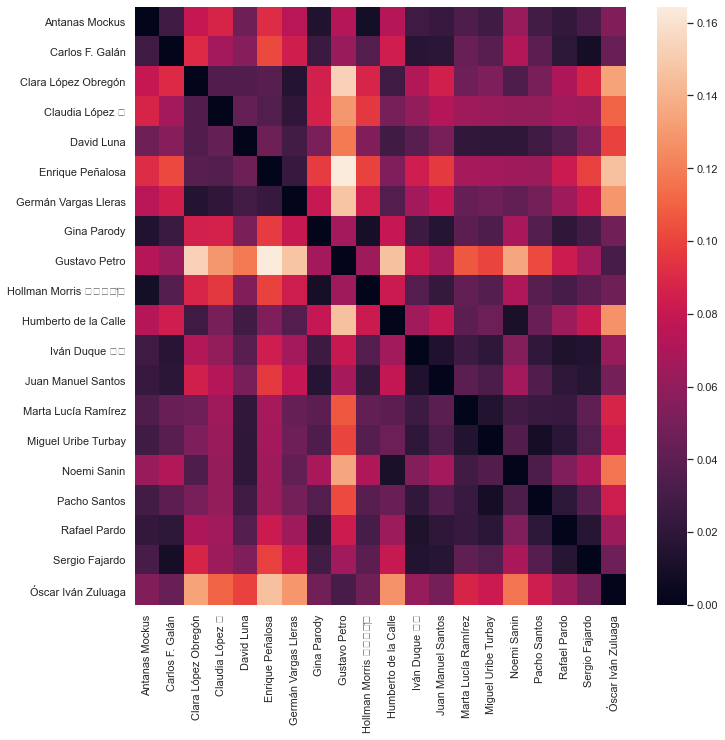

In [64]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 20 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_tw = list(grouped_data2[:num_of_texts].username)
corpora_tw = list(grouped_data2[:num_of_texts]['lemmatized_text'])
L = []
for p in corpora_tw:
    l = []
    for q in corpora_tw:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_tw, index = fileids_tw)
ax = sns.heatmap(div)
plt.show()

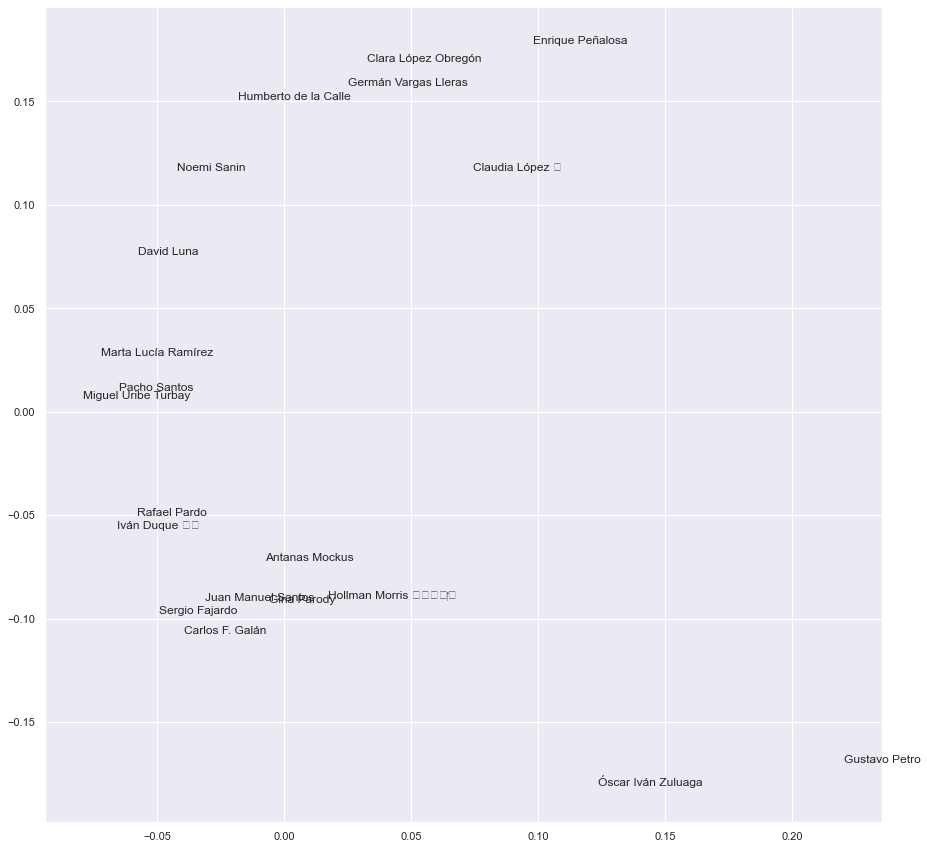

In [65]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (15,15))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_tw):
    ax.annotate(txt, (x[i],y[i]))

## This seems really interesting!! Although, I'm not sure yet what it implies. But mapping the semantic similarity of the diferent candidates' aggregated tweets seems to be related to their political positions in the spectrum. I'll have to think more about this! What is clear from this is that Gustavo Petro has adopted a very different way of communicating from the otheres.